In [1]:
import qiskit
from qiskit_aer import AerSimulator
from qiskit import transpile, QuantumCircuit
from qiskit_aer import noise
from qiskit.quantum_info import Statevector
import math
from qiskit.visualization import plot_histogram, plot_state_city

#### RACSimulator : Built on top of Qiskit Aer

In [6]:
class RACSimulator(AerSimulator):
    def __init__(self, method='statevector', configuration=None, properties=None, provider=None, target=None, **backend_options):
        super().__init__(method=method)
        self.initial_state = None

    def run_and_keep(self, qc_i, shots=1024, noise=0, noise_model=None):
        simulator=AerSimulator()
        if noise == 0:
            qc = QuantumCircuit(qc_i.num_qubits)
            if self.initial_state != None:
                qc.set_statevector(self.initial_state)
            qc.compose(qc_i, inplace=True, front=False)
            qc.save_statevector()
            qc = transpile(qc, simulator)
            result = simulator.run(qc, shots=shots).result()
            output_state = result.get_statevector(qc)

        elif noise == 1:
            qc = QuantumCircuit(qc_i.num_qubits)
            if self.initial_state != None:
                qc.set_density_matrix(self.initial_state)
            qc.compose(qc_i,inplace=True,front=False)
            qc.save_density_matrix()
            qc = transpile(qc, simulator)
            result = simulator.run(qc, shots=shots, noise_model=noise_model).result()
            output_state = result.data(0)['density_matrix']

        self.initial_state = output_state

        return result, output_state, qc

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))
Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
            dims=(2, 2))
{'counts': {'0x0': 486, '0x3': 538}, 'statevector': Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
            dims=(2, 2))}


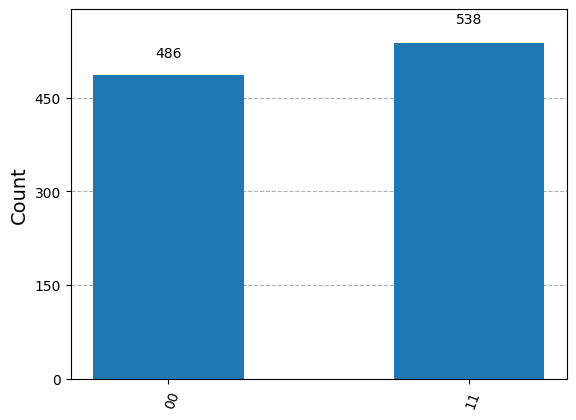

In [17]:
noiseless_simulator = RACSimulator()

qc1 = QuantumCircuit(2)
qc1.h(0)
qc1.cx(0, 1)

result1, sv_1, qc1 = noiseless_simulator.run_and_keep(qc1)

qc2 = QuantumCircuit(2,2)
qc2.measure(0,0)
qc2.measure(1,1)

result2, sv_2, qc2 = noiseless_simulator.run_and_keep(qc2)

print(sv_1)
print(sv_2)
print(result2.data())

# data = [result1.get_counts(),result2.get_counts()]
# plot_histogram(data, legend=['counts before measurements','counts after measurements'] ,title='Historgam')
plot_histogram(result2.get_counts())



{'11': 448, '01': 54, '00': 467, '10': 55}


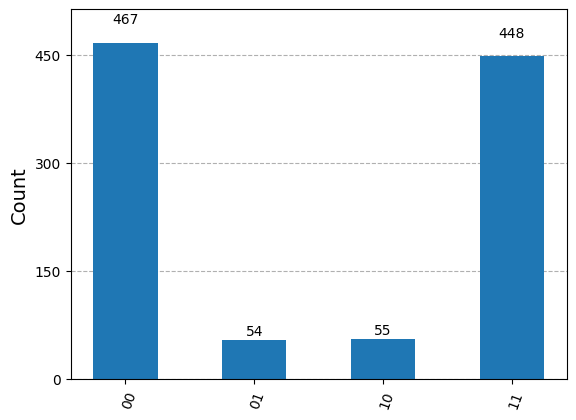

In [15]:
noisy_simulator = RACSimulator(method='density_matrix')

prob = 0.2
error = noise.depolarizing_error(prob, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['cx'])

qc3 = QuantumCircuit(2)
qc3.h(0)
qc3.cx(0, 1)

result3, sv_3, qc3 = noisy_simulator.run_and_keep(qc3, noise=1, noise_model=noise_model)

qc4 = QuantumCircuit(2,2)
qc4.measure(0,0)
qc4.measure(1,1)

result4, sv_4, qc4 = noisy_simulator.run_and_keep(qc4, noise=1, noise_model=noise_model)


# print(sv_3)
# print(sv_4)

print(result4.get_counts())
plot_histogram(result4.get_counts())
# print(result3.data())

# data = [result3.get_counts(),result4.get_counts()]
# plot_histogram(data, legend=['counts before measurements','counts after measurements'] ,title='Historgam')






#### TO DO 

- calc overhead of run_and_keep VS run
- calc space complexity in terms of qubit (exp)
- try approach 2 ****
- more generic: simulators not only aer